# HPCG
## flop_sp_efficiency profile and combined trace

## flop_sp_efficiency

Profiled on g3.4xlarge (M60), CUDA9.0
```
$ nvprof --csv --log-file HPCG_M60_flops.csv --metrics flop_dp_efficiency,flop_sp_efficiency hpcg3.1/xhpcg-3.1_gcc_485_cuda90176_ompi_1_10_2_sm_35_sm_50_sm_60_sm_70_ver_10_8_17
```

In [3]:
%matplotlib inline
import re
import numpy as np
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import os.path
import datetime
from cycler import cycler
import pandas as pd

In [22]:
filename_nvprof_flops_chainer = "HPCG_M60_flops.csv"

maxrows = None


In [24]:
file1 = filename_nvprof_flops_chainer
print "Reading",file1

Reading HPCG_M60_flops.csv


In [79]:
print file1
df = pd.read_csv(file1, header = 0, skiprows=[0,1,2,3,4], nrows = maxrows)
print df.shape

HPCG_M60_flops.csv
(96, 8)


In [80]:
df.iloc[:3]

,Device,Kernel,Invocations,Metric Name,Metric Description,Min,Max,Avg
0,Tesla M60 (0),"sort_matrix_kernel(double*, int*, int)",4,flop_dp_efficiency,FLOP Efficiency(Peak Double),0.000000%,0.000000%,0.000000%
1,Tesla M60 (0),"sort_matrix_kernel(double*, int*, int)",4,flop_sp_efficiency,FLOP Efficiency(Peak Single),0.000000%,0.000000%,0.000000%
2,Tesla M60 (0),"void dot_kernel<double, double, double, int=12...",367,flop_dp_efficiency,FLOP Efficiency(Peak Double),1.393133%,1.598564%,1.540048%


#### Parse data to float

In [81]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(s):
    global pat
    if type(s) is not str:
        return s
    f = pat.search(s)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [82]:
df[['Min','Max','Avg']] = df[['Min','Max','Avg']].applymap(parseFloat)

In [83]:
df.iloc[:3]

,Device,Kernel,Invocations,Metric Name,Metric Description,Min,Max,Avg
0,Tesla M60 (0),"sort_matrix_kernel(double*, int*, int)",4,flop_dp_efficiency,FLOP Efficiency(Peak Double),0.000000,0.000000,0.000000
1,Tesla M60 (0),"sort_matrix_kernel(double*, int*, int)",4,flop_sp_efficiency,FLOP Efficiency(Peak Single),0.000000,0.000000,0.000000
2,Tesla M60 (0),"void dot_kernel<double, double, double, int=12...",367,flop_dp_efficiency,FLOP Efficiency(Peak Double),1.393133,1.598564,1.540048


### Aggregate values for min, max and avg for all kernels

#### Remove unused columns

In [84]:
df_parts = df.drop(columns = ['Device', 'Kernel', 'Invocations', 'Metric Description']).fillna(0)
df_parts.iloc[:3]

,Metric Name,Min,Max,Avg
0,flop_dp_efficiency,0.000000,0.000000,0.000000
1,flop_sp_efficiency,0.000000,0.000000,0.000000
2,flop_dp_efficiency,1.393133,1.598564,1.540048


In [85]:
# Check invalid data: nvprof --replace-mode application can produce invalid values
df_invalid = df_parts[(df_parts['Max'] > 100)]
df_invalid

,Metric Name,Min,Max,Avg


#### Remove all-zero rows

In [86]:
df_nonzero = df_parts[(df_parts['Max'] != 0) & (df_parts['Avg'] != 0) & (df_parts['Min'] != 0)]

In [87]:
df_nonzero.iloc[:3]

,Metric Name,Min,Max,Avg
2,flop_dp_efficiency,1.393133,1.598564,1.540048
6,flop_dp_efficiency,0.003966,0.004798,0.004492
12,flop_dp_efficiency,0.041848,7.494099,2.171702


In [88]:
# Check if we have nonzero SP effeciency
sp = df_nonzero[df_nonzero["Metric Name"] == "flop_sp_efficiency"]
sp

,Metric Name,Min,Max,Avg


In [89]:
# Check if we have nonzero DP effeciency
dp = df_nonzero[df_nonzero["Metric Name"] == "flop_dp_efficiency"]
dp.shape

(28, 4)

### Plot distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115984810>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x1159cde50>]], dtype=object)

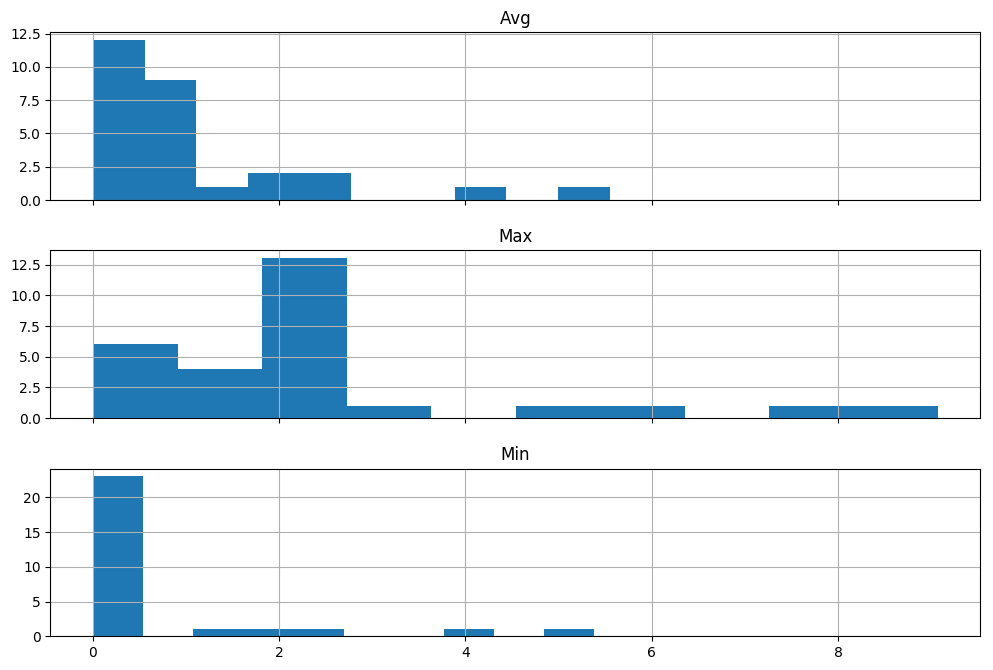

In [90]:
df_nonzero.hist(layout=(3,1),sharex=True)

### Aggregate values for Min, Max and Avg

In [44]:
df_piv = pd.pivot_table(df_nonzero, values=['Min','Max','Avg'], index='Metric Name',
                        aggfunc={'Min':np.min, 'Max':np.max, 'Avg':np.mean})
df_piv

,Avg,Max,Min
Metric Name,,,
flop_dp_efficiency,1.082184,9.072376,0.000156


In [45]:
df_piv_mean = pd.pivot_table(df_nonzero, values=['Min','Max','Avg'], index='Metric Name',
                        aggfunc={'Min':np.mean, 'Max':np.mean, 'Avg':np.mean})
df_piv_mean

,Avg,Max,Min
Metric Name,,,
flop_dp_efficiency,1.082184,2.429819,0.534466



<div style="display:block;margin:50px;font-size:200%;line-height:200%;">
    Maximum DP efficiency for HPCG is ≈9%.<br>
    Average: ≈1%.
</div>

# Plot combined profiling

In [5]:
time_field_index = 0
duration_field_index = 1
SSMem_field_index = 9
DSMem_field_index = 10
size_field_index = 11
throughput_field_index = 12
src_field_index = 13
dst_field_index = 14
context_index = 16
stream_index = 17
name_field_index = 18

title_pattern = re.compile("^(Start|s).*")
cuda_pattern = re.compile("\[CUDA .*\]")

columns = [time_field_index, duration_field_index,
           size_field_index, throughput_field_index,
           src_field_index, dst_field_index,
           context_index, stream_index,
           name_field_index]

maxrows = None

In [6]:
filename_nvsmi_hpcg = "nvidia-smi-hpcg_comb.csv"
filename_nvprof_hpcg = "nvprof-trace-hpcg_comb-44387.csv"

df_nvprof = pd.read_csv(filename_nvprof_hpcg,header = 0, usecols = columns, skiprows=[0,1,2,4], nrows = maxrows)
df_nvprof.iloc[-5:]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
4660354,62.206826,2.208,0.007812,0.003374,Device,Pageable,1,7,[CUDA memcpy DtoH]
4660355,62.206850,1.344,NaN,NaN,NaN,NaN,1,7,"WAXPBY_kernel(double*, double, double*, double..."
4660356,62.206977,1.280,32.000000,23.841858,Device,Device,1,7,[CUDA memcpy DtoD]
4660357,62.206992,1.824,NaN,NaN,NaN,NaN,1,7,"perm_kernel(double*, double*, int*, int) [4377..."
4660358,62.207000,5.088,32.000000,5.997952,Device,Pinned,1,7,[CUDA memcpy DtoH]


# Remove rows with no Throughput

In [8]:
df_nvprof = df_nvprof.loc[df_nvprof["Throughput"].notnull()]
df_nvprof.iloc[-5:]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
4660346,62.206661,2.112,0.007812,0.003528,Device,Pageable,1,7,[CUDA memcpy DtoH]
4660351,62.206780,2.112,0.007812,0.003528,Device,Pageable,1,7,[CUDA memcpy DtoH]
4660354,62.206826,2.208,0.007812,0.003374,Device,Pageable,1,7,[CUDA memcpy DtoH]
4660356,62.206977,1.280,32.000000,23.841858,Device,Device,1,7,[CUDA memcpy DtoD]
4660358,62.207000,5.088,32.000000,5.997952,Device,Pinned,1,7,[CUDA memcpy DtoH]


In [9]:
print df_nvprof.Name.unique()

['[CUDA memcpy HtoD]' '[CUDA memset]' '[CUDA memcpy DtoH]'
 '[CUDA memcpy DtoD]']


In [10]:
df_nomemset = df_nvprof.loc[~df_nvprof["Name"].str.contains("memset")]

In [11]:
print df_nomemset.Name.unique()

['[CUDA memcpy HtoD]' '[CUDA memcpy DtoH]' '[CUDA memcpy DtoD]']


In [12]:
dd = df_nomemset.loc[df_nomemset["Name"].str.contains("DtoD")]
dd.iloc[:3]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
137,0.805688,1.856,32.0,16.442661,Device,Device,1,7,[CUDA memcpy DtoD]
139,0.805721,1.472,32.0,20.732050,Device,Device,1,7,[CUDA memcpy DtoD]
141,0.805750,1.632,32.0,18.699496,Device,Device,1,7,[CUDA memcpy DtoD]


In [13]:
dh = df_nomemset.loc[~df_nomemset["Name"].str.contains("DtoD")]
dh.iloc[:3]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
0,0.573196,1.472,0.109375,0.070861,Pageable,Device,1,7,[CUDA memcpy HtoD]
3,0.601854,2.432,0.003906,0.001532,Device,Pageable,1,7,[CUDA memcpy DtoH]
9,0.605561,2.752,0.105469,0.036549,Device,Pageable,1,7,[CUDA memcpy DtoH]


Text(0,0.5,u'Throughput (GB/s)')

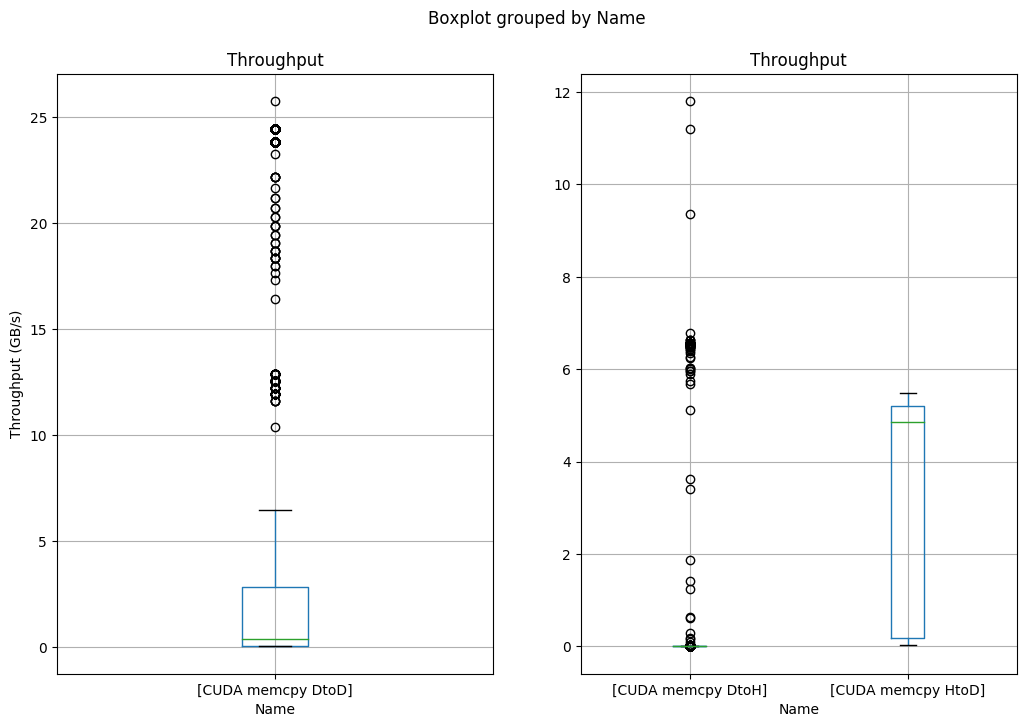

In [15]:
plt.rcParams['figure.figsize'] = 12,8
fig, axarr = plt.subplots(1,2)
dd.boxplot(column="Throughput",by="Name",ax=axarr[0])
dh.boxplot(column="Throughput",by="Name",ax=axarr[1])
axarr[0].set_ylabel('Throughput (GB/s)')
#ax = plt.gca()
#ax.set_ylabel('Throughput (GB/s)')

In [16]:
print df_nvprof.columns
df_nvprof.iloc[:3]

Index([u'Start', u'Duration', u'Size', u'Throughput', u'SrcMemType',
       u'DstMemType', u'Context', u'Stream', u'Name'],
      dtype='object')


,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
0,0.573196,1.472,0.109375,0.070861,Pageable,Device,1,7,[CUDA memcpy HtoD]
1,0.601747,2.624,0.003906,0.001420,Device,NaN,1,7,[CUDA memset]
3,0.601854,2.432,0.003906,0.001532,Device,Pageable,1,7,[CUDA memcpy DtoH]


In [17]:
df_nvprof['FullName']  = df_nvprof.loc[:,'Name'] + " " + df_nvprof.loc[:,'SrcMemType']+ df_nvprof.loc[:,'DstMemType'].fillna("")

In [18]:
df_nvprof[pd.isnull(df_nvprof["FullName"])]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name,FullName


In [19]:
# Convert unique values in column "FullName" to new columns
def mergeColumnNames(df_org):
    df = df_org.pivot(index="Start", columns="FullName", values = 'Throughput')
    df = df.fillna(0)  # Fill empty cells with 0-s
    return df

In [20]:
df_throughput = mergeColumnNames(df_nvprof)

In [21]:
df_throughput.iloc[:3]

FullName,[CUDA memcpy DtoD] DeviceDevice,[CUDA memcpy DtoH] DevicePageable,[CUDA memcpy DtoH] DevicePinned,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice,[CUDA memset] Device
Start,,,,,,
0.573196,0.0,0.000000,0.0,0.070861,0.0,0.00000
0.601747,0.0,0.000000,0.0,0.000000,0.0,0.00142
0.601854,0.0,0.001532,0.0,0.000000,0.0,0.00000


In [46]:
df_memcpy = df_throughput.filter(regex=("^((?!memset).)*$"))
df_memcpy.iloc[:3]

FullName,[CUDA memcpy DtoD] DeviceDevice,[CUDA memcpy DtoH] DevicePageable,[CUDA memcpy DtoH] DevicePinned,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice
Start,,,,,
0.573196,0.0,0.000000,0.0,0.070861,0.0
0.601747,0.0,0.000000,0.0,0.000000,0.0
0.601854,0.0,0.001532,0.0,0.000000,0.0


In [47]:
def appendMaxValues2ColumnNames(df,series):
    cols = len(df.columns)
    col_names = []
    for i in range(0,cols):
        name = df.columns[i].replace("[CUDA memcpy ","")
        name = name.replace("]","")
        col_names.append(series+name+" " +'{:.3f}'.format(df.iloc[:,i].max()))
    df.columns = col_names
    return df

In [48]:
df_memcpy = appendMaxValues2ColumnNames(df_memcpy,"")

In [49]:
df_memcpy.columns

Index([u'DtoD DeviceDevice 25.775', u'DtoH DevicePageable 11.806',
       u'DtoH DevicePinned 6.623', u'HtoD PageableDevice 1.355',
       u'HtoD PinnedDevice 5.481'],
      dtype='object')

In [50]:
dd = df_memcpy.filter(regex=(".*DtoD.+"))
dd.iloc[:3]

,DtoD DeviceDevice 25.775
Start,
0.573196,0.0
0.601747,0.0
0.601854,0.0


In [51]:
dh = df_memcpy.filter(regex=(".*(HtoD|DtoH).*"))
dh.iloc[:3]

,DtoH DevicePageable 11.806,DtoH DevicePinned 6.623,HtoD PageableDevice 1.355,HtoD PinnedDevice 5.481
Start,,,,
0.573196,0.000000,0.0,0.070861,0.0
0.601747,0.000000,0.0,0.000000,0.0
0.601854,0.001532,0.0,0.000000,0.0


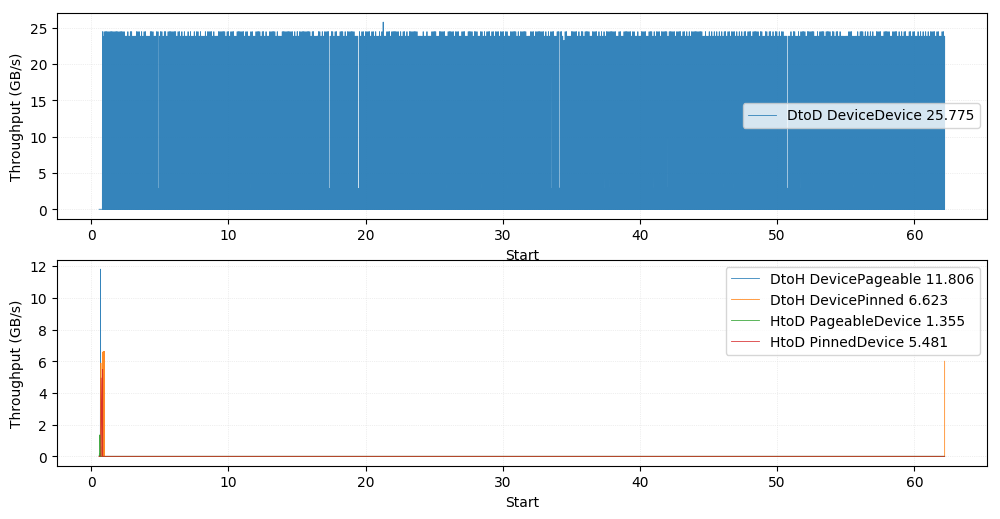

In [52]:
plt.rcParams['figure.figsize'] = 12,6
fig, axarr = plt.subplots(2)
dd.plot(linewidth=0.6,alpha=0.9,ax = axarr[0])
dh.plot(linewidth=0.6,alpha=0.9,ax = axarr[1])
for ax in axarr:
    ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    ax.set_ylabel('Throughput (GB/s)')

In [53]:
# PCI express x3 bandwidth
PCI3_band = 16 # GB/s

In [54]:
# Device DRAM bandwidth
# Memory clock rate
GHz=5
# Interface width
bit=256

DRAM_GBs=(GHz * 1e9 * (bit/8)) / 1e9
print DRAM_GBs

160.0


#### Normalize H<->D throughput

In [62]:
norm = df_memcpy.copy()
print type(df_memcpy),df_memcpy[:1].shape
print type(norm),norm[:1].shape
norm.iloc[:7]

<class 'pandas.core.frame.DataFrame'> (1420, 5)
<class 'pandas.core.frame.DataFrame'> (1420, 5)


,DtoD DeviceDevice 25.775,DtoH DevicePageable 11.806,DtoH DevicePinned 6.623,HtoD PageableDevice 1.355,HtoD PinnedDevice 5.481
Start,,,,,
0.573196,0.0,0.000000,0.0,0.070861,0.0
0.601747,0.0,0.000000,0.0,0.000000,0.0
0.601854,0.0,0.001532,0.0,0.000000,0.0
0.605447,0.0,0.000000,0.0,0.000000,0.0
0.605454,0.0,0.000000,0.0,0.000000,0.0
0.605460,0.0,0.000000,0.0,0.000000,0.0
0.605465,0.0,0.000000,0.0,0.000000,0.0


In [63]:
df_memcpy[df_memcpy.iloc[:,0] > 25]

,DtoD DeviceDevice 25.775,DtoH DevicePageable 11.806,DtoH DevicePinned 6.623,HtoD PageableDevice 1.355,HtoD PinnedDevice 5.481
Start,,,,,
21.278029,25.774982,0.0,0.0,0.0,0.0


In [64]:
DRAM_GBs

160.0

In [65]:
def normalize(x,max = 16):
    #print "max=",max 
    if isinstance(x,int) or isinstance(x,float):
        if x == 0:
            return 0
        else:
            x_ = float(x)
            max_ = float(max)
            norm = (x_/max_)*100
            #print x_,norm
            return norm
    elif x is None:
        return x
    else:
        print "Wrong parameter type:",type(x)

def normalize_df(x,max = 16):
    #print type(x)
    if isinstance(x,int) or isinstance(x,float):
        return normalize(x,max)
    else:
        #print x.values
        x = x.apply(normalize,max=max)
        #print "Returned:",type(x)
        #print x.values
        return x
    
       
norm.iloc[:,2:] = norm.iloc[:,2:].apply(normalize_df, max = PCI3_band)
norm.iloc[:,0] = norm.iloc[:,0].apply(normalize_df, max = DRAM_GBs)
norm[df_memcpy.iloc[:,0] > 25]

,DtoD DeviceDevice 25.775,DtoH DevicePageable 11.806,DtoH DevicePinned 6.623,HtoD PageableDevice 1.355,HtoD PinnedDevice 5.481
Start,,,,,
21.278029,16.109364,0.0,0.0,0.0,0.0


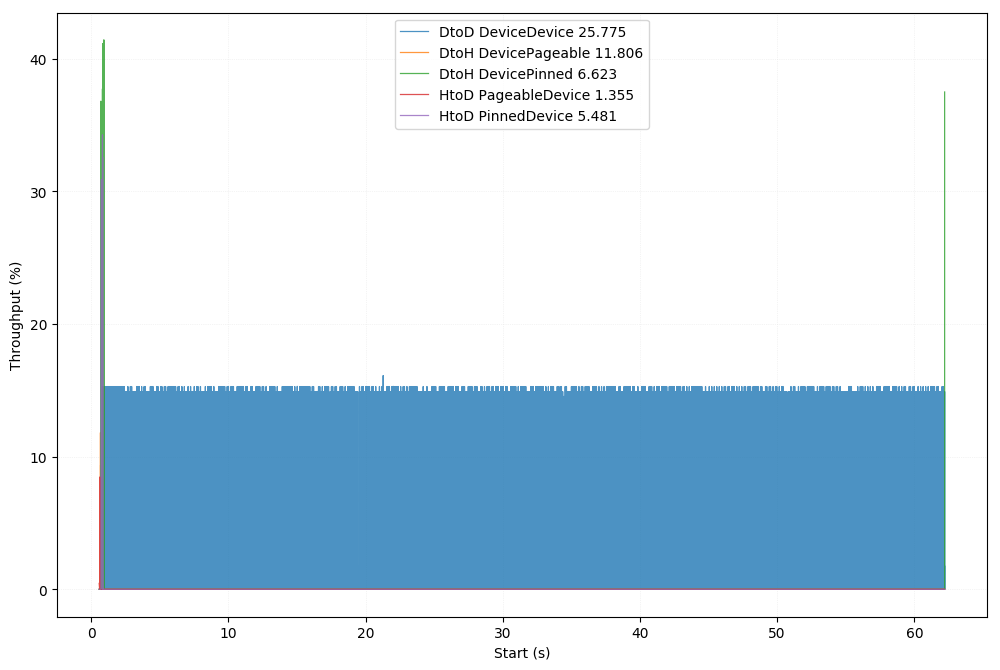

In [78]:
plt.rcParams['figure.figsize'] = 12,8
norm.plot(linewidth=0.9,alpha=0.8)
ax = plt.gca()
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5,alpha=0.7)
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5,alpha=0.7)
#ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.set_xlabel('Start (s)')
ax.set_ylabel('Throughput (%)')
plt.show()

## Plot smi data

In [68]:
filename = filename_nvsmi_hpcg
print "Reading",filename

smi_data = pd.read_csv(filename)
smi_data.iloc[:3]
start = 0

Reading nvidia-smi-hpcg_comb.csv


In [69]:
# Parse date from readable format to seconds
def parseTime(date_time):
    global start
    dt_obj = datetime.datetime.strptime(date_time, "%Y/%m/%d %H:%M:%S.%f")
    seconds = 0
    if start == 0:
        start = dt_obj
    else:
        seconds = (dt_obj - start).total_seconds()
    return seconds

In [70]:
smi_data["sec"] = smi_data["timestamp"].apply(parseTime)
smi_data.iloc[:3]

,timestamp,name,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%],sec
0,2018/01/24 09:41:04.519,Tesla M60,7613 MiB,0 MiB,98 %,8 %,0.000
1,2018/01/24 09:41:04.834,Tesla M60,7613 MiB,0 MiB,100 %,9 %,0.315
2,2018/01/24 09:41:05.046,Tesla M60,7613 MiB,0 MiB,97 %,10 %,0.527


In [71]:
smi_data.set_index("sec", drop=True, inplace=True)
smi_data.iloc[:3]

,timestamp,name,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%]
sec,,,,,,
0.000,2018/01/24 09:41:04.519,Tesla M60,7613 MiB,0 MiB,98 %,8 %
0.315,2018/01/24 09:41:04.834,Tesla M60,7613 MiB,0 MiB,100 %,9 %
0.527,2018/01/24 09:41:05.046,Tesla M60,7613 MiB,0 MiB,97 %,10 %


In [72]:
smi_data = smi_data.drop(columns = ['timestamp', ' name'])

In [73]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(str):
    global pat
    f = pat.search(str)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [74]:
smi_data = smi_data.applymap(parseFloat)
smi_data.iloc[:3]

,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%]
sec,,,,
0.000,7613.0,0.0,98.0,8.0
0.315,7613.0,0.0,100.0,9.0
0.527,7613.0,0.0,97.0,10.0


In [75]:
smi_MB = smi_data.filter(regex=(".*\[MiB.*"))
smi_pr = smi_data.filter(regex=(".*\[\%.*"))
smi_pr.iloc[-5:]

,utilization.gpu [%],utilization.memory [%]
sec,,
60.798,84.0,4.0
60.899,84.0,4.0
60.999,84.0,3.0
61.099,84.0,3.0
61.200,84.0,3.0


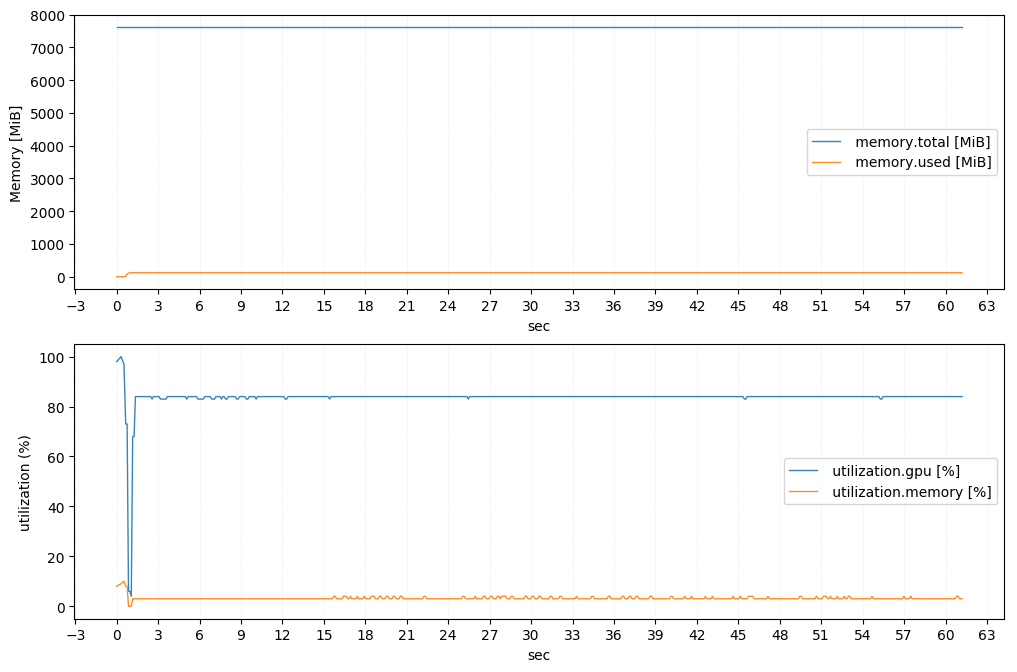

In [76]:
plt.rcParams['figure.figsize'] = 12,8
fig, axarr = plt.subplots(2)
smi_MB.plot(linewidth=1,alpha=0.9,ax = axarr[0])
smi_pr.plot(linewidth=1,alpha=0.9,ax = axarr[1])
axarr[0].set_ylabel('Memory [MiB]')
axarr[1].set_ylabel('utilization (%)')
for axis in axarr:
    axis.legend()
    axis.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    axis.xaxis.set_major_locator(plt.MaxNLocator(24))
    #axis.xaxis.set_major_locator(dates.SecondLocator(bysecond = range(120), interval = 10))
    #axis.xaxis.set_minor_locator(dates.MicrosecondLocator(interval = 1000))
    #axis.xaxis.set_major_formatter(dates.DateFormatter('%S:%f'))
plt.show()